In [1]:
import pandas as pd
from lib.trees import get_tree, parse_edge_list
from lib.dataset import split_training_validation
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import random

2025-05-29 21:17:57.892322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748546277.908867 3319969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748546277.913609 3319969 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748546277.924249 3319969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748546277.924269 3319969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748546277.924271 3319969 computation_placer.cc:177] computation placer alr

In [2]:
sentences = pd.read_csv("../data/train.csv")
sentences["language"] = sentences["language"].astype("category")
sentences["edgelist"] = sentences["edgelist"].apply(parse_edge_list)
sentences["tree"] = sentences["edgelist"].apply(get_tree)
sentences.head()

,language,sentence,n,edgelist,root,tree
0,Japanese,2,23,"[(6, 4), (2, 6), (2, 23), (20, 2), (15, 20), (...",10,"(6, 4, 2, 23, 20, 15, 3, 5, 14, 8, 12, 9, 18, ..."
1,Japanese,5,18,"[(8, 9), (14, 8), (4, 14), (5, 4), (1, 2), (6,...",10,"(8, 9, 14, 4, 5, 1, 2, 6, 17, 12, 3, 7, 11, 16..."
2,Japanese,8,33,"[(2, 10), (2, 14), (4, 2), (16, 4), (6, 16), (...",3,"(2, 10, 14, 4, 16, 6, 12, 32, 26, 3, 29, 27, 2..."
3,Japanese,11,30,"[(30, 1), (14, 24), (21, 14), (3, 21), (7, 3),...",30,"(30, 1, 14, 24, 21, 3, 7, 12, 27, 16, 8, 5, 26..."
4,Japanese,12,19,"[(19, 13), (16, 19), (2, 16), (4, 10), (4, 15)...",11,"(19, 13, 16, 2, 4, 10, 15, 5, 14, 12, 3, 1, 8,..."


In [3]:
random.seed(42)
training, validation = split_training_validation(sentences, 0.2)

print("Training set size:", len(training))
print("Validation set size:", len(validation))

Training set size: 8400
Validation set size: 2100


Our first approach will be the example given by the statement. We'll unwind the the tree into a list of nodes, each
with a set of centrality scores.

In [21]:
from typing import List


def get_longest_paths(graph) -> List[List]:
    """
    Find all longest simple path in an undirected graph.
    """
    longest_paths = []
    longest_path_length = 0
    for source in graph.nodes():
        for target in graph.nodes():
            if source == target:
                continue
            # Find all simple paths between source and target
            paths = nx.all_simple_paths(graph, source=source, target=target)
            for path in paths:
                if len(path) > longest_path_length:
                    longest_path_length = len(path)
                    longest_paths.clear()
                    longest_paths.append(path)
                elif len(path) == longest_path_length:
                    longest_paths.append(path)
    return longest_paths


def unwind_tree(row: pd.Series) -> pd.DataFrame:
    """
    Unwind a tree into a list of nodes, with their centrality scores.
    """
    tree: nx.Graph = row["tree"]
    root_node = row["root"]
    language = row["language"]

    # Centrality measures
    eccentricity = nx.eccentricity(tree)  # Maximum distance to any other node in the tree.
    closeness_centrality = nx.closeness_centrality(tree)  # Reciprocal avg distance to all other nodes in the tree.
    degree_centrality = nx.degree_centrality(tree)  # Fraction of nodes that a node is connected to.
    betweenness_centrality = nx.betweenness_centrality(tree)  # Fraction of shortest paths that pass through.
    harmonic_centrality = nx.harmonic_centrality(tree)  # Average distance to all other nodes in the tree.
    pagerank = nx.pagerank(tree)  # PageRank algorithm, which measures the importance of nodes.
    katz_centrality = nx.katz_centrality(tree)  # It's a generalization of eigenvector centrality.
    current_flow_closeness = nx.current_flow_closeness_centrality(tree)  # Closeness cent. based on resistance.
    current_flow_betweenness = nx.current_flow_betweenness_centrality(tree)  # Betweenness cent. based on resistance.
    load_centrality = nx.load_centrality(tree)  # Similar to betweenness centrality.
    percolation_centrality = nx.percolation_centrality(tree)  # Proportion of "percolation" paths through a node.
    second_order_centrality = nx.second_order_centrality(tree)  # Std of return times in perpetual random walk.
    laplacian_centrality = nx.laplacian_centrality(tree)  # Centrality based on the Laplacian matrix.

    # Tree properties
    tree_diameter = nx.diameter(tree)  # Length of the longest path in the tree.
    # Get the centroids of the tree
    centroids = nx.center(tree)
    # Get the leaves of the tree
    leaves = [node for node, degree in tree.degree() if degree == 1]
    # Get the longest path in the tree
    longest_path = get_longest_paths(tree)
    longest_path_nodes = set()
    for path in longest_path:
        longest_path_nodes.update(path)

    rows = []
    for node in tree:
        # Create a tree rooted at the current node
        tree_rooted_at_node: nx.DiGraph = nx.bfs_tree(tree, source=node)
        # We can do this because we know it will be a tree, so no cycles exist
        # and thus, bfs_edges will give us a valid tree structure.

        subtrees: list[nx.DiGraph] = []
        for child in tree.neighbors(node):
            subtrees.append(nx.bfs_tree(tree, source=child))

        subtree_leaves = []
        for subtree in subtrees:
            subtree_leaves.append([n for n in subtree if subtree.out_degree[n] == 0])

        subtree_depths = []
        for subtree in subtrees:
            subtree_depths.append(nx.dag_longest_path_length(subtree))

        rows.append(
            {
                "row_index": row.name,
                "node": node,
                "is_root": node == root_node,
                # Global properties
                "language": language,
                "tree_diameter": tree_diameter,
                "tree_size": tree.number_of_nodes(),
                "tree_edges": tree.number_of_edges(),
                "number_of_centroids": len(centroids),
                "average_degree": sum(dict(tree.degree()).values()) / tree.number_of_nodes(),
                "number_of_leaves": len(leaves),
                # Local Node Properties
                "degree": tree.degree[node],
                "is_leaf": tree.degree[node] == 1,  # Only a leaf can have degree 1
                "is_centroid": node in centroids,
                # Path properties
                "distance_to_closest_centroid": min(
                    nx.shortest_path_length(tree, source=c, target=node) for c in centroids
                ),
                "distance_to_farthest_centroid": max(
                    nx.shortest_path_length(tree, source=c, target=node) for c in centroids
                ),
                "distance_to_closest_leaf": min(nx.shortest_path_length(tree, source=l, target=node) for l in leaves),
                "distance_to_farthest_leaf": max(nx.shortest_path_length(tree, source=l, target=node) for l in leaves),
                "is_in_longest_path": node in longest_path_nodes,
                # Properties of tree rooted at this node
                "tree_depth_if_root": nx.dag_longest_path_length(tree_rooted_at_node),
                "min_subtree_size_if_root": min(subtree.number_of_nodes() for subtree in subtrees) if subtrees else 0,
                "max_subtree_size_if_root": max(subtree.number_of_nodes() for subtree in subtrees) if subtrees else 0,
                "average_subtree_size_if_root": (
                    sum(subtree.number_of_nodes() for subtree in subtrees) / len(subtrees) if subtrees else 0
                ),
                "min_subtree_leaf_count_if_root": (min(len(l) for l in subtree_leaves) if subtree_leaves else 0),
                "max_subtree_leaf_count_if_root": (max(len(l) for l in subtree_leaves) if subtree_leaves else 0),
                "average_subtree_leaf_count_if_root": (
                    sum(len(l) for l in subtree_leaves) / len(subtree_leaves) if subtree_leaves else 0
                ),
                "min_subtree_depth_if_root": (min(subtree_depths) if subtree_depths else 0),
                "max_subtree_depth_if_root": (max(subtree_depths) if subtree_depths else 0),
                "average_subtree_depth_if_root": (sum(subtree_depths) / len(subtree_depths) if subtree_depths else 0),
                "depth_difference_if_root": (max(subtree_depths) - min(subtree_depths)) if subtree_depths else 0,
                "number_of_subtrees_if_root": len(subtrees),
                # Centrality measures
                "eccentricity": eccentricity[node],
                "closeness_centrality": closeness_centrality[node],
                "closeness_centrality_inverse": 1 / closeness_centrality[node] if closeness_centrality[node] > 0 else 0,
                "degree_centrality": degree_centrality[node],
                "harmonic_centrality": harmonic_centrality[node],
                "betweenness_centrality": betweenness_centrality[node],
                "pagerank": pagerank[node],
                "katz_centrality": katz_centrality[node],
                "current_flow_closeness": current_flow_closeness[node],
                "current_flow_betweenness": current_flow_betweenness[node],
                "load_centrality": load_centrality[node],
                "percolation_centrality": percolation_centrality[node],
                "second_order_centrality": second_order_centrality[node],
                "laplacian_centrality": laplacian_centrality[node],
            }
        )
    return pd.DataFrame(rows)

In [ ]:
validation_unwound = pd.concat(validation.apply(unwind_tree, axis=1).tolist(), ignore_index=True)
validation_unwound["language"] = validation_unwound["language"].astype("category")
validation_unwound.to_csv("../data/cache/validation_unwound.csv", index=False)
validation_unwound.head()

,row_index,node,is_root,language,tree_diameter,tree_size,tree_edges,number_of_centroids,average_degree,number_of_leaves,...,harmonic_centrality,betweenness_centrality,pagerank,katz_centrality,current_flow_closeness,current_flow_betweenness,load_centrality,percolation_centrality,second_order_centrality,laplacian_centrality
0,4,19,False,Japanese,9,19,18,2,1.894737,8,...,5.745238,0.111111,0.058419,0.226827,0.012500,0.111111,0.111111,0.111111,75.749587,0.096774
1,4,13,False,Japanese,9,19,18,2,1.894737,8,...,4.463095,0.000000,0.032723,0.205624,0.010309,0.000000,0.000000,0.000000,91.224997,0.048387
2,4,16,False,Japanese,9,19,18,2,1.894737,8,...,6.800000,0.209150,0.053434,0.233236,0.015385,0.209150,0.209150,0.209150,58.804762,0.145161
3,4,2,False,Japanese,9,19,18,2,1.894737,8,...,8.600000,0.738562,0.097469,0.276120,0.019231,0.738562,0.738562,0.738562,38.496753,0.290323
4,4,4,False,Japanese,9,19,18,2,1.894737,8,...,6.844048,0.313725,0.111026,0.269181,0.011905,0.313725,0.313725,0.313725,79.661785,0.241935


In [ ]:
training_unwound = pd.concat(training.apply(unwind_tree, axis=1).tolist(), ignore_index=True)
training_unwound["language"] = training_unwound["language"].astype("category")
training_unwound.to_csv("../data/cache/training_unwound.csv", index=False)
training_unwound.head()

,row_index,node,is_root,language,tree_diameter,tree_size,tree_edges,number_of_centroids,average_degree,number_of_leaves,...,harmonic_centrality,betweenness_centrality,pagerank,katz_centrality,current_flow_closeness,current_flow_betweenness,load_centrality,percolation_centrality,second_order_centrality,laplacian_centrality
0,0,6,False,Japanese,14,23,22,1,1.913043,6,...,5.823846,0.090909,0.048565,0.209086,0.007246,0.090909,0.090909,0.090909,98.762341,0.101449
1,0,4,False,Japanese,14,23,22,1,1.913043,6,...,4.561122,0.000000,0.027162,0.188298,0.006289,0.000000,0.000000,0.000000,112.481110,0.043478
2,0,2,False,Japanese,14,23,22,1,1.913043,6,...,6.991703,0.255411,0.066901,0.228660,0.008403,0.255411,0.255411,0.255411,84.451169,0.159420
3,0,23,False,Japanese,14,23,22,1,1.913043,6,...,5.157179,0.000000,0.025477,0.190256,0.007143,0.000000,0.000000,0.000000,100.149888,0.057971
4,0,20,False,Japanese,14,23,22,1,1.913043,6,...,7.146825,0.311688,0.042552,0.213357,0.009615,0.311688,0.311688,0.311688,71.147734,0.130435


In [27]:
print("Training unwound size:", len(training_unwound))
print("Validation unwound size:", len(validation_unwound))

Training unwound size: 157588
Validation unwound size: 39891


Now that we have a sea of features, let's perform some exploratory data analysis to see if we can find any correlations.

<Axes: >

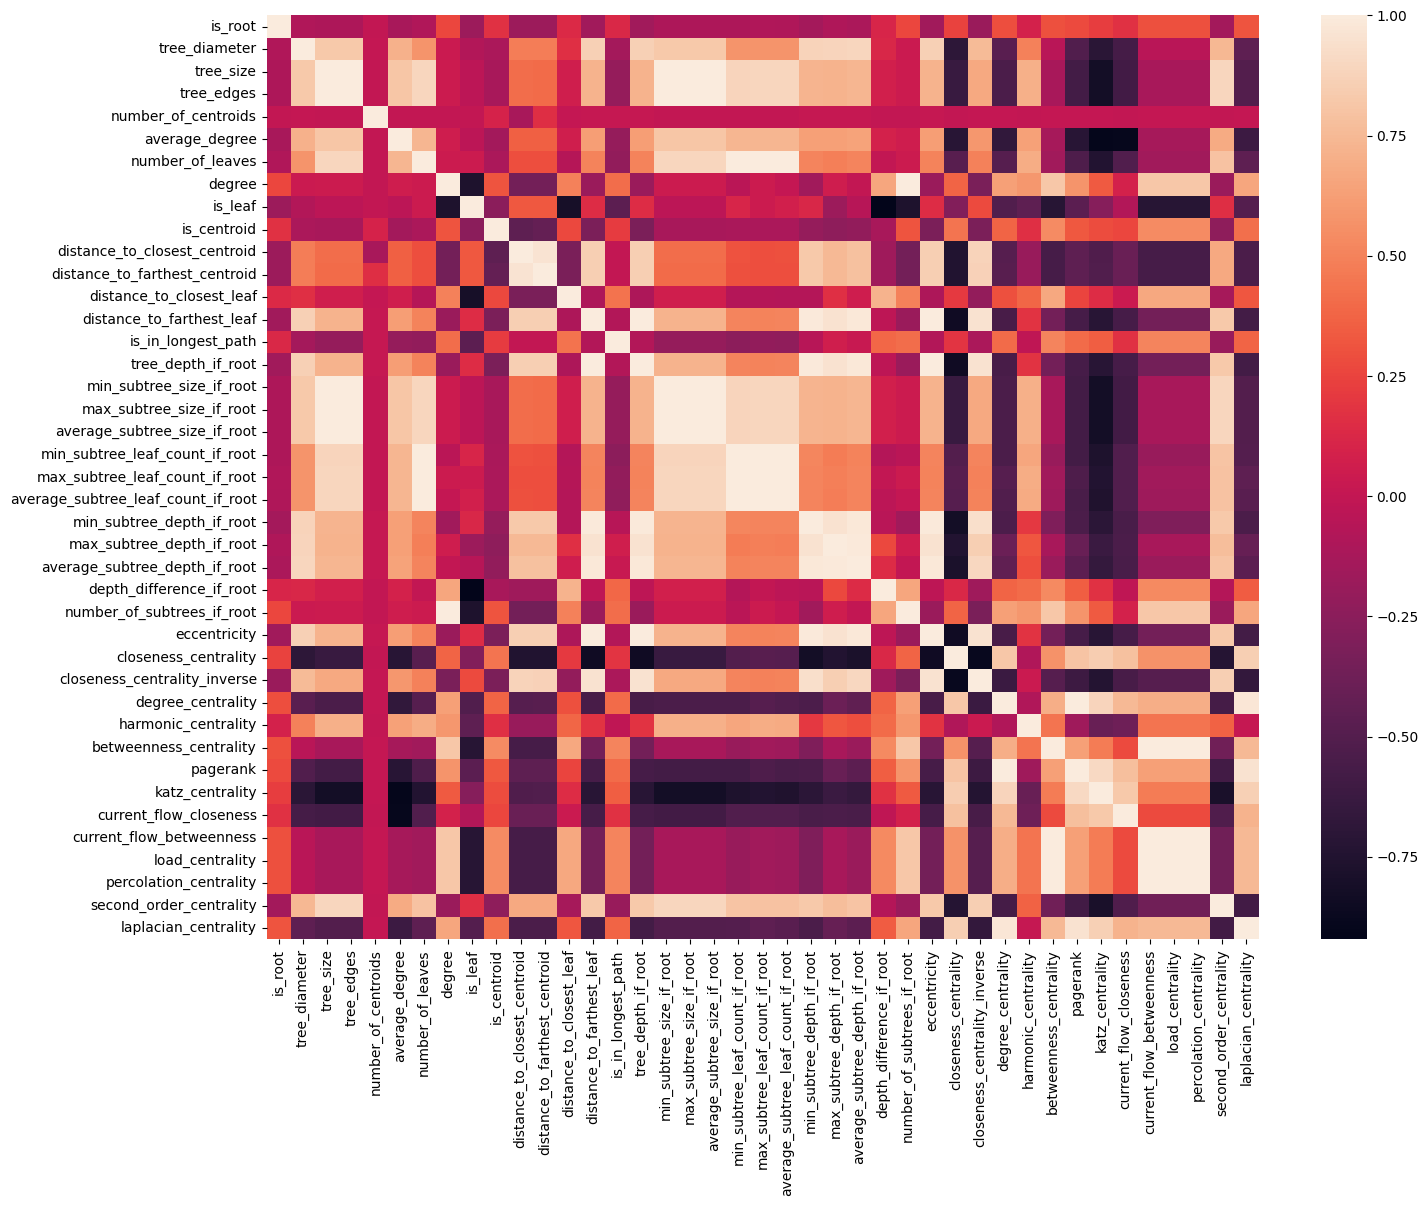

In [46]:
# To get the corr plot, drop the "row_index" and the "node" columns
def drop_columns_for_corr_plot(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(columns=["row_index", "node", "language"])


corr = drop_columns_for_corr_plot(training_unwound).corr()
round(corr, 2)
plt.figure(figsize=(16, 12))
sns.heatmap(corr)